## Descartes Underwriting Assignment
### Omar EL MELLOUKI



During this project we'll try to extract insight from the data we've been provided. The goal is to analyse the data, comprehend it, and predict the *TARGET_FLAG* column given the relevant features. 

This presentation will be organized as such : 
* First Look and Problem Framing
* Data Preprocessing 
* Exploratory Data Analysis 
* First Baseline Modeling 
* Final Model and Prediction 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
import seaborn as sns
random.seed(42)

# First look at the data

We start by looking at the raw data to better understand the task at hand. 

In [2]:
data = pd.read_csv('data/train_auto.csv')
print('Number of instances {:d} \nNumber of features {:d}'.format(data.shape[0], data.shape[1]))

Number of instances 8161 
Number of features 26


In [3]:
pd.set_option('display.max_columns', None)
data.head()
data_init = data.copy()

We can already notice that we'll drop the *Index* column, as it provides no information, while the *TARGET_AMT* does not concern us. 

In [4]:
data.info()
data.columns[data.isnull().any()].tolist()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8161 entries, 0 to 8160
Data columns (total 26 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   INDEX        8161 non-null   int64  
 1   TARGET_FLAG  8161 non-null   int64  
 2   TARGET_AMT   8161 non-null   float64
 3   KIDSDRIV     8161 non-null   int64  
 4   AGE          8155 non-null   float64
 5   HOMEKIDS     8161 non-null   int64  
 6   YOJ          7707 non-null   float64
 7   INCOME       7716 non-null   object 
 8   PARENT1      8161 non-null   object 
 9   HOME_VAL     7697 non-null   object 
 10  MSTATUS      8161 non-null   object 
 11  SEX          8161 non-null   object 
 12  EDUCATION    8161 non-null   object 
 13  JOB          7635 non-null   object 
 14  TRAVTIME     8161 non-null   int64  
 15  CAR_USE      8161 non-null   object 
 16  BLUEBOOK     8161 non-null   object 
 17  TIF          8161 non-null   int64  
 18  CAR_TYPE     8161 non-null   object 
 19  RED_CA

['AGE', 'YOJ', 'INCOME', 'HOME_VAL', 'JOB', 'CAR_AGE']

We can begin to notice that there are 4 **float** numerical features, 8 **integer** numerical features, and 14 **object** features, for a total of 26 features including our target feature. As we loaded the data from a *.csv* file we can assume these will be strings. We also notice that several columns include 
We now look more specifically at the target. 

In [5]:
TARGET = data['TARGET_FLAG']
print('The values the target feature can take are', TARGET.unique())
print('The dataset contains {:.1f}% positive instances'.format(TARGET.mean()*100))

The values the target feature can take are [0 1]
The dataset contains 26.4% positive instances


In [6]:
# We drop the Target AMT and Index columns
def drop_col(df):
    df.drop(['INDEX', 'TARGET_AMT'], axis = 1, inplace = True)
drop_col(data)

**From this first analysis we can conclude that this problem is an unbalanced binary classification problem, based on 23 features and 8161 instances.**
We now move on to cleaning the dataset. 

# Data Preprocessing 

As we've noticed during our first look at the data, there are several transformations that need to be performed in order to prepare the data for modeling. Let's start with the type preparation. 

### Converting the object columns 

We start by dealing with the object features.

In [7]:
# Object Features
obj_data = data.select_dtypes('object')
obj_data.head()

,INCOME,PARENT1,HOME_VAL,MSTATUS,SEX,EDUCATION,JOB,CAR_USE,BLUEBOOK,CAR_TYPE,RED_CAR,OLDCLAIM,REVOKED,URBANICITY
0,"$67,349",No,$0,z_No,M,PhD,Professional,Private,"$14,230",Minivan,yes,"$4,461",No,Highly Urban/ Urban
1,"$91,449",No,"$257,252",z_No,M,z_High School,z_Blue Collar,Commercial,"$14,940",Minivan,yes,$0,No,Highly Urban/ Urban
2,"$16,039",No,"$124,191",Yes,z_F,z_High School,Clerical,Private,"$4,010",z_SUV,no,"$38,690",No,Highly Urban/ Urban
3,NaN,No,"$306,251",Yes,M,<High School,z_Blue Collar,Private,"$15,440",Minivan,yes,$0,No,Highly Urban/ Urban
4,"$114,986",No,"$243,925",Yes,z_F,PhD,Doctor,Private,"$18,000",z_SUV,no,"$19,217",Yes,Highly Urban/ Urban


In [8]:
obj_data.columns

Index(['INCOME', 'PARENT1', 'HOME_VAL', 'MSTATUS', 'SEX', 'EDUCATION', 'JOB',
       'CAR_USE', 'BLUEBOOK', 'CAR_TYPE', 'RED_CAR', 'OLDCLAIM', 'REVOKED',
       'URBANICITY'],
      dtype='object')

In [9]:
obj_data.apply(pd.unique)

INCOME        [$67,349 , $91,449 , $16,039 , nan, $114,986 ,...
PARENT1                                               [No, Yes]
HOME_VAL      [$0 , $257,252 , $124,191 , $306,251 , $243,92...
MSTATUS                                             [z_No, Yes]
SEX                                                    [M, z_F]
EDUCATION     [PhD, z_High School, <High School, Bachelors, ...
JOB           [Professional, z_Blue Collar, Clerical, Doctor...
CAR_USE                                   [Private, Commercial]
BLUEBOOK      [$14,230 , $14,940 , $4,010 , $15,440 , $18,00...
CAR_TYPE      [Minivan, z_SUV, Sports Car, Van, Panel Truck,...
RED_CAR                                               [yes, no]
OLDCLAIM      [$4,461 , $0 , $38,690 , $19,217 , $2,374 , $5...
REVOKED                                               [No, Yes]
URBANICITY         [Highly Urban/ Urban, z_Highly Rural/ Rural]
dtype: object

There are different type of object features : 
* Binary data such as Sex or MStatus
* Categorical data such as Education or Job
* 'Dollar' data which require special treatment like Income or Bluebook
We will also deal with missing values during the process

#### Binary data
The binary columns are *PARENT1*, *MSTATUS*, *SEX*, *RED_CAR*, *CAR_USE* , *URBANICITY* ,*REVOKED*

In [10]:
BINARY = ['PARENT1', 'MSTATUS', 'SEX', 'RED_CAR', 'CAR_USE', 'URBANICITY', 'REVOKED']

#Check they're really binary 
obj_data[BINARY].apply(pd.unique)

,PARENT1,MSTATUS,SEX,RED_CAR,CAR_USE,URBANICITY,REVOKED
0,No,z_No,M,yes,Private,Highly Urban/ Urban,No
1,Yes,Yes,z_F,no,Commercial,z_Highly Rural/ Rural,Yes


In [11]:
# We define a function replace the categories with binaries

def binarize(df):
    dict_replace = {

        'z_No' : 0,
        'No' : 0,
        'Yes' : 1,
        'M' : 0,
        'z_F' : 1,
        'no' : 0,
        'yes' : 1,
        'Private' : 0,
        'Commercial' : 1,
        'Highly Urban/ Urban' :1,
        'z_Highly Rural/ Rural' : 0
    }

    # We replace the object binary values with integer data
    df.replace(dict_replace, inplace = True)

binarize(data)

In [12]:
data[BINARY].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8161 entries, 0 to 8160
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   PARENT1     8161 non-null   int64
 1   MSTATUS     8161 non-null   int64
 2   SEX         8161 non-null   int64
 3   RED_CAR     8161 non-null   int64
 4   CAR_USE     8161 non-null   int64
 5   URBANICITY  8161 non-null   int64
 6   REVOKED     8161 non-null   int64
dtypes: int64(7)
memory usage: 446.4 KB


In [13]:
data[BINARY].head()

,PARENT1,MSTATUS,SEX,RED_CAR,CAR_USE,URBANICITY,REVOKED
0,0,0,0,1,0,1,0
1,0,0,0,1,1,1,0
2,0,1,1,0,0,1,0
3,0,1,0,1,0,1,0
4,0,1,1,0,0,1,1


#### Ordinal Encoding 
We now deal with the *EDUCATION* column, and encode it in a way that keeps the hierarchy between the values.

In [14]:
print('The different categories for the EDUCATION column :', data['EDUCATION'].unique())

def ordinal(df):

    EDUCATION_DICT = {
        'PhD' : 4,
        'Masters' : 3,
        'Bachelors' : 2,
        'z_High School' : 1,
        '<High School' : 0
    }
    
    df.replace(EDUCATION_DICT, inplace = True)

The different categories for the EDUCATION column : ['PhD' 'z_High School' '<High School' 'Bachelors' 'Masters']


In [15]:
ordinal(data)
data['EDUCATION']

0       4
1       1
2       1
3       0
4       4
       ..
8156    1
8157    4
8158    3
8159    2
8160    1
Name: EDUCATION, Length: 8161, dtype: int64

In [16]:
# Checking the transformation worked 
data.head()

,TARGET_FLAG,KIDSDRIV,AGE,HOMEKIDS,YOJ,INCOME,PARENT1,HOME_VAL,MSTATUS,SEX,EDUCATION,JOB,TRAVTIME,CAR_USE,BLUEBOOK,TIF,CAR_TYPE,RED_CAR,OLDCLAIM,CLM_FREQ,REVOKED,MVR_PTS,CAR_AGE,URBANICITY
0,0,0,60.0,0,11.0,"$67,349",0,$0,0,0,4,Professional,14,0,"$14,230",11,Minivan,1,"$4,461",2,0,3,18.0,1
1,0,0,43.0,0,11.0,"$91,449",0,"$257,252",0,0,1,z_Blue Collar,22,1,"$14,940",1,Minivan,1,$0,0,0,0,1.0,1
2,0,0,35.0,1,10.0,"$16,039",0,"$124,191",1,1,1,Clerical,5,0,"$4,010",4,z_SUV,0,"$38,690",2,0,3,10.0,1
3,0,0,51.0,0,14.0,NaN,0,"$306,251",1,0,0,z_Blue Collar,32,0,"$15,440",7,Minivan,1,$0,0,0,0,6.0,1
4,0,0,50.0,0,NaN,"$114,986",0,"$243,925",1,1,4,Doctor,36,0,"$18,000",1,z_SUV,0,"$19,217",2,1,3,17.0,1


#### One Hot Encoding for Multi Categories Features
Before dealing with the 'dollar' data, we one hot encode the data with multiple labels *ie* *CAR_TYPE* and *JOB*.

In [17]:
MULTI = ['CAR_TYPE', 'JOB']
data[MULTI].info()

# JOB is missing values, we'll replace them with the most common one
print(data['JOB'].value_counts())
most_common = data['JOB'].value_counts().index[0]
print('Most common job :', most_common)

# We replace 
def replace_job(df):
    df['JOB'].fillna(most_common, inplace = True)

# We check 
replace_job(data)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8161 entries, 0 to 8160
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   CAR_TYPE  8161 non-null   object
 1   JOB       7635 non-null   object
dtypes: object(2)
memory usage: 127.6+ KB
z_Blue Collar    1825
Clerical         1271
Professional     1117
Manager           988
Lawyer            835
Student           712
Home Maker        641
Doctor            246
Name: JOB, dtype: int64
Most common job : z_Blue Collar
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8161 entries, 0 to 8160
Data columns (total 24 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   TARGET_FLAG  8161 non-null   int64  
 1   KIDSDRIV     8161 non-null   int64  
 2   AGE          8155 non-null   float64
 3   HOMEKIDS     8161 non-null   int64  
 4   YOJ          7707 non-null   float64
 5   INCOME       7716 non-null   object 
 6   PARENT1      8161 no

In [18]:
# Now we use a one hot encoder to encode the multi category label
from sklearn.preprocessing import OneHotEncoder

def one_hot_encode(df):
    ohe = OneHotEncoder(sparse = False)
    ohe.fit(df[MULTI])

    # We one hot encode the data
    categories = ohe.categories_
    encoding = ohe.transform(df[MULTI])

    # We add them to the data frame
    i = 0
    for hots in categories:
        for category in hots: 
            df[category] = encoding[:,i]
            i += 1 

    df.drop(MULTI, axis = 1, inplace = True)

one_hot_encode(data)
data.head()

,TARGET_FLAG,KIDSDRIV,AGE,HOMEKIDS,YOJ,INCOME,PARENT1,HOME_VAL,MSTATUS,SEX,EDUCATION,TRAVTIME,CAR_USE,BLUEBOOK,TIF,RED_CAR,OLDCLAIM,CLM_FREQ,REVOKED,MVR_PTS,CAR_AGE,URBANICITY,Minivan,Panel Truck,Pickup,Sports Car,Van,z_SUV,Clerical,Doctor,Home Maker,Lawyer,Manager,Professional,Student,z_Blue Collar
0,0,0,60.0,0,11.0,"$67,349",0,$0,0,0,4,14,0,"$14,230",11,1,"$4,461",2,0,3,18.0,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0,0,43.0,0,11.0,"$91,449",0,"$257,252",0,0,1,22,1,"$14,940",1,1,$0,0,0,0,1.0,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0,0,35.0,1,10.0,"$16,039",0,"$124,191",1,1,1,5,0,"$4,010",4,0,"$38,690",2,0,3,10.0,1,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,0,51.0,0,14.0,NaN,0,"$306,251",1,0,0,32,0,"$15,440",7,1,$0,0,0,0,6.0,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0,0,50.0,0,NaN,"$114,986",0,"$243,925",1,1,4,36,0,"$18,000",1,0,"$19,217",2,1,3,17.0,1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Encoding the dollar features 
We now deal with the features containing dollar signs and convert them to floating point numbers.

In [19]:
DOLLAR = ['INCOME', 'HOME_VAL', 'BLUEBOOK', 'OLDCLAIM']

def remove_dlr(df):
    
    df[DOLLAR] = df[DOLLAR].replace('[\$,]', '', regex=True).astype(float)

remove_dlr(data)

In [20]:
data.head()

,TARGET_FLAG,KIDSDRIV,AGE,HOMEKIDS,YOJ,INCOME,PARENT1,HOME_VAL,MSTATUS,SEX,EDUCATION,TRAVTIME,CAR_USE,BLUEBOOK,TIF,RED_CAR,OLDCLAIM,CLM_FREQ,REVOKED,MVR_PTS,CAR_AGE,URBANICITY,Minivan,Panel Truck,Pickup,Sports Car,Van,z_SUV,Clerical,Doctor,Home Maker,Lawyer,Manager,Professional,Student,z_Blue Collar
0,0,0,60.0,0,11.0,67349.0,0,0.0,0,0,4,14,0,14230.0,11,1,4461.0,2,0,3,18.0,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0,0,43.0,0,11.0,91449.0,0,257252.0,0,0,1,22,1,14940.0,1,1,0.0,0,0,0,1.0,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0,0,35.0,1,10.0,16039.0,0,124191.0,1,1,1,5,0,4010.0,4,0,38690.0,2,0,3,10.0,1,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,0,51.0,0,14.0,NaN,0,306251.0,1,0,0,32,0,15440.0,7,1,0.0,0,0,0,6.0,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0,0,50.0,0,NaN,114986.0,0,243925.0,1,1,4,36,0,18000.0,1,0,19217.0,2,1,3,17.0,1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


### Conclusion of the preliminary study 

At this point we have clearly defined the problem : Unbalanced binary classification problem of TARGET_FLAG. 
We have also removed irrelevant columns, dealt with the currency features, and turned the object features into floats and integers. We process the test data in the same way and save the .csv files for later use. 

In [21]:
data.to_csv('data/preprocessed_train.csv', index = False)

In [22]:
# Preprocessing the test data
def preprocessing(df):
    drop_col(df)
    ordinal(df)
    replace_job(df)
    one_hot_encode(df)
    binarize(df)
    remove_dlr(df)

In [23]:
test_data = pd.read_csv('data/test_auto.csv')
preprocessing(test_data)
test_data.to_csv('data/preprocessed_test.csv', index = False)

# Exploratory Data Analysis and Processing

In this part we will analyze the data and deal with the missing values in the training and test set. 

## Exploratory Data Analysis 



In [24]:
data = pd.read_csv('data/preprocessed_train.csv')
data.head()

,TARGET_FLAG,KIDSDRIV,AGE,HOMEKIDS,YOJ,INCOME,PARENT1,HOME_VAL,MSTATUS,SEX,EDUCATION,TRAVTIME,CAR_USE,BLUEBOOK,TIF,RED_CAR,OLDCLAIM,CLM_FREQ,REVOKED,MVR_PTS,CAR_AGE,URBANICITY,Minivan,Panel Truck,Pickup,Sports Car,Van,z_SUV,Clerical,Doctor,Home Maker,Lawyer,Manager,Professional,Student,z_Blue Collar
0,0,0,60.0,0,11.0,67349.0,0,0.0,0,0,4,14,0,14230.0,11,1,4461.0,2,0,3,18.0,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0,0,43.0,0,11.0,91449.0,0,257252.0,0,0,1,22,1,14940.0,1,1,0.0,0,0,0,1.0,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0,0,35.0,1,10.0,16039.0,0,124191.0,1,1,1,5,0,4010.0,4,0,38690.0,2,0,3,10.0,1,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,0,51.0,0,14.0,NaN,0,306251.0,1,0,0,32,0,15440.0,7,1,0.0,0,0,0,6.0,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0,0,50.0,0,NaN,114986.0,0,243925.0,1,1,4,36,0,18000.0,1,0,19217.0,2,1,3,17.0,1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


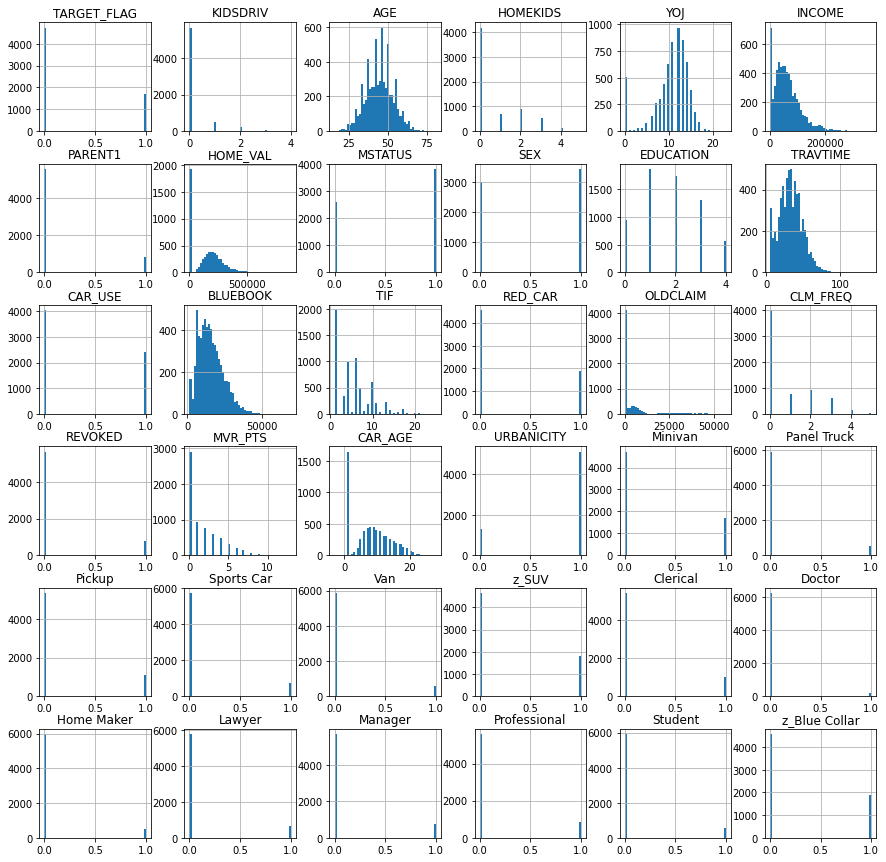

In [25]:
# As the number of instances with missing values is quite small compared to the 
# size of the training set, we can drop them for the EDA

data.dropna(inplace = True)

# We plot the distributions of the data
data.hist(bins = 50, figsize = (15,15))
plt.show()

We can already see that the data is not in the same scale. We will need to rescale it later during the processing phase. 
We will look at the features that are correlated to the target. 

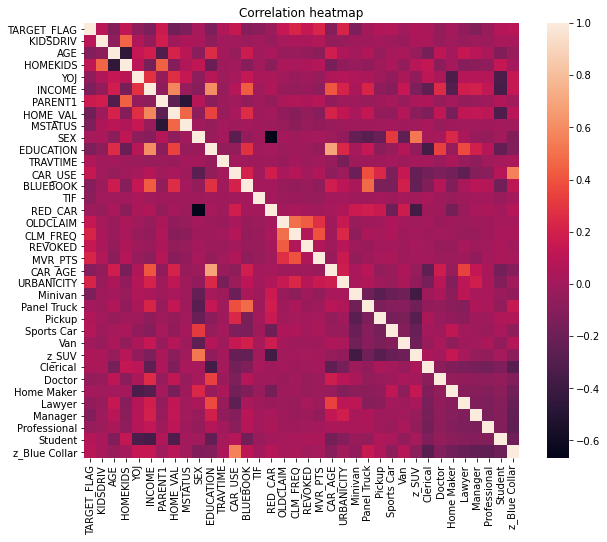

In [26]:
f, ax = plt.subplots(figsize=(10, 8))
corr = data.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool),square=True, ax=ax)
plt.title('Correlation heatmap')
plt.show()

We can notice some expected correlations, like the positive correlation between home value and the income. The blue collar individuals also seem to use their cars more than the other occupations. There also several informations that we can find in the correlation between the variables, but we focus on the correlation between the target and the features. 
The TARGET_FLAG feature seems to positively correlate with MVR_PTS, CLM_FREQ, and URBANICITY. 

In [27]:
corr_matrix = data.corr()
abs(corr_matrix['TARGET_FLAG']).sort_values(ascending = False)

TARGET_FLAG      1.000000
MVR_PTS          0.225479
CLM_FREQ         0.222084
URBANICITY       0.219242
HOME_VAL         0.180141
PARENT1          0.164052
REVOKED          0.146289
CAR_USE          0.144823
OLDCLAIM         0.140237
Minivan          0.138679
INCOME           0.137238
EDUCATION        0.134558
MSTATUS          0.134028
Manager          0.115218
HOMEKIDS         0.114991
AGE              0.112937
CAR_AGE          0.106247
BLUEBOOK         0.105811
KIDSDRIV         0.092513
z_Blue Collar    0.091916
TIF              0.078964
Student          0.074061
YOJ              0.065745
Sports Car       0.062702
Lawyer           0.057591
TRAVTIME         0.053116
Doctor           0.052398
Pickup           0.051765
z_SUV            0.046597
Professional     0.040454
Clerical         0.038105
SEX              0.021397
RED_CAR          0.015523
Home Maker       0.006902
Panel Truck      0.004553
Van              0.000485
Name: TARGET_FLAG, dtype: float64

## Data Processing 

In order to avoid data leak into the validation set we'll start by splitting the data into train and validation set, then fit the imputers to the train set and use it to deal with the validation set. 
When splitting the data we'll also be careful to split it by respecting the proportion of each category in the target set. 

* The numeric values will be scaled to [0,1]
* We will use a mean imputer


Columns with missing values: ['AGE', 'YOJ', 'INCOME', 'HOME_VAL', 'CAR_AGE']

Preview of data with null values:
xxxxxxxxxxxxx


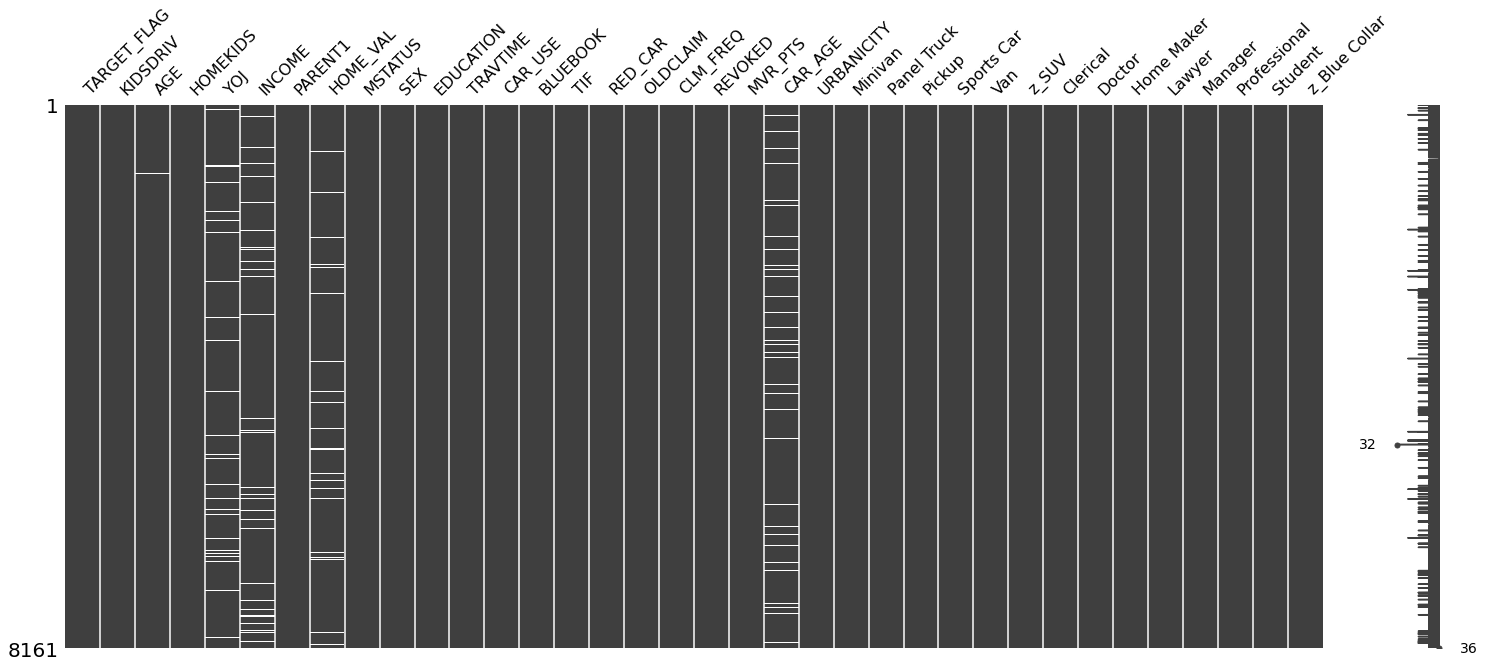


No duplicated entries found


In [28]:
data = pd.read_csv('data/preprocessed_train.csv')

#!pip install missingno
import missingno

# The columns with nan values 
print('Columns with missing values:', data.columns[data.isnull().any()].tolist())

def check_nan(data):
    if data.isnull().any(axis=None):
        print("\nPreview of data with null values:\nxxxxxxxxxxxxx")
        #print(data[data.isnull().any(axis=1)].head(3))
        missingno.matrix(data)
        plt.show()

check_nan(data)
# We also check for duplicate data 

def check_duplicate(data) : 
    if len(data[data.duplicated()]) > 0:
        print("No. of duplicated entries: ", len(data[data.duplicated()]))
        print(data[data.duplicated(keep=False)].sort_values(by=list(data.columns)).head())
    else:
        print("\nNo duplicated entries found")

check_duplicate(data)
# To get a better estimate for the nan values, a better idea would be to replace
# the nan values with the mean across the category
# For instance, replace the missing income of a doctor with the average income of the other doctors in the set

In [29]:
# We split the data into training and validation
# We'll use stratified sampling to avoid sampling bias and get 
# a training and validation set with approximately 25% of positive instances  
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits= 1, test_size = 0.2, random_state = 42)

for train_index, test_index in split.split(data, data['TARGET_FLAG']):
    
    strat_train_set = data.loc[train_index]
    strat_val_set = data.loc[test_index]

In [30]:
# We check we have the same proportion 

print('The train dataset contains {:.1f}% positive instances'.format(strat_train_set['TARGET_FLAG'].mean()*100))
print('The validation dataset contains {:.1f}% positive instances'.format(strat_val_set['TARGET_FLAG'].mean()*100))


The train dataset contains 26.4% positive instances
The validation dataset contains 26.4% positive instances


In [31]:
# We build the feature and target features then deal with the missing values 
X_train = strat_train_set.drop('TARGET_FLAG', axis = 1)
y_train = strat_train_set['TARGET_FLAG']

X_val = strat_val_set.drop('TARGET_FLAG', axis = 1)
y_val = strat_val_set['TARGET_FLAG']

In [32]:
# Missing values imputation
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler 
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

X_train.head(2)

,KIDSDRIV,AGE,HOMEKIDS,YOJ,INCOME,PARENT1,HOME_VAL,MSTATUS,SEX,EDUCATION,TRAVTIME,CAR_USE,BLUEBOOK,TIF,RED_CAR,OLDCLAIM,CLM_FREQ,REVOKED,MVR_PTS,CAR_AGE,URBANICITY,Minivan,Panel Truck,Pickup,Sports Car,Van,z_SUV,Clerical,Doctor,Home Maker,Lawyer,Manager,Professional,Student,z_Blue Collar
1874,0,46.0,0,8.0,NaN,0,NaN,0,1,3,17,0,18220.0,6,0,0.0,0,0,0,NaN,1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1421,0,50.0,0,12.0,218705.0,0,0.0,0,0,4,47,1,28370.0,14,0,4558.0,2,0,8,15.0,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [33]:
NUM_COLS = ['AGE', 'YOJ', 'INCOME','HOME_VAL', 'TRAVTIME', 'BLUEBOOK', 'TIF', 'CAR_AGE']

numeric_preprocessing = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('imputer', SimpleImputer(missing_values = np.nan, strategy='mean'))])

preprocessor = ColumnTransformer(
    transformers = [('numeric', numeric_preprocessing, NUM_COLS)],
    remainder='passthrough'
)

In [34]:
# We fit on the training data to avoid data leak 
preprocessor.fit(X_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('numeric',
                                 Pipeline(steps=[('scaler', StandardScaler()),
                                                 ('imputer', SimpleImputer())]),
                                 ['AGE', 'YOJ', 'INCOME', 'HOME_VAL',
                                  'TRAVTIME', 'BLUEBOOK', 'TIF', 'CAR_AGE'])])

In [35]:
X_train = preprocessor.transform(X_train)
X_val = preprocessor.transform(X_val)

In [36]:
X_train.shape
X_val.shape

(1633, 35)

Our data is now ready for modeling, we'll start with a baseline model, then try to produce a better one. 
We also need to choose an evaluation metric. As we're in binary classification we have several possibilities :
 * Classification accuracy, but with an imbalanced dataset it would give us a false sense of accuracy  
 * The area under the receiver operating characteristic curve (AUROC)
 * The F1 Score 
 
 We'll use the F1 Score as the data is highly imbalanced

# Baseline Model 

We'll use a dummy classifier to predict the most common class, before moving on to a first baseline model. 



In [37]:
from sklearn.dummy import DummyClassifier

dummy = DummyClassifier(strategy = 'most_frequent')
dummy.fit(X_train, y_train )

DummyClassifier(strategy='most_frequent')

In [38]:
from sklearn.metrics import f1_score, accuracy_score
y_pred = dummy.predict(X_val)

# The accuracy score to get a feel 
print('Accuracy score', accuracy_score(y_pred, y_val))
print('F1 Score', f1_score(y_pred, y_val))

Accuracy score 0.736068585425597
F1 Score 0.0


Now we implement a simple predictive model 

In [39]:
from sklearn.linear_model import LogisticRegression 

log_reg = LogisticRegression(max_iter = 1000, random_state = 42)
log_reg.fit(X_train, y_train)

y_pred = log_reg.predict(X_val)

print('Accuracy score', accuracy_score(y_pred, y_val))
print('F1 Score', f1_score(y_pred, y_val))

Accuracy score 0.7862829148805879
F1 Score 0.49346879535558785


As expected the accuracy is a bad indicator of the predictation. 

# Final Model
For the final model we use LightGBM

In [40]:
#!pip install lightgbm
import lightgbm as lgb
light = lgb.LGBMClassifier(objective = 'binary', metric = 'binary_logloss', random_state = 42)

lgb_classifier = lgb.LGBMClassifier()

lgb_classifier = lgb_classifier.fit(X=X_train, y=y_train)

In [41]:
y_pred = lgb_classifier.predict(X_val)

print('Accuracy score', accuracy_score(y_pred, y_val))
print('F1 Score', f1_score(y_pred, y_val))


from sklearn.model_selection import cross_val_score
scores = cross_val_score(lgb_classifier, X_train, y_train, cv=5, scoring = 'f1', n_jobs = -1)
print("%0.2f F1-score with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

Accuracy score 0.8058787507654623
F1 Score 0.5834428383705651
0.53 F1-score with a standard deviation of 0.02


# Computing the final prediction 

We now process the test set and compute the final prediction. 


Preview of data with null values:
xxxxxxxxxxxxx


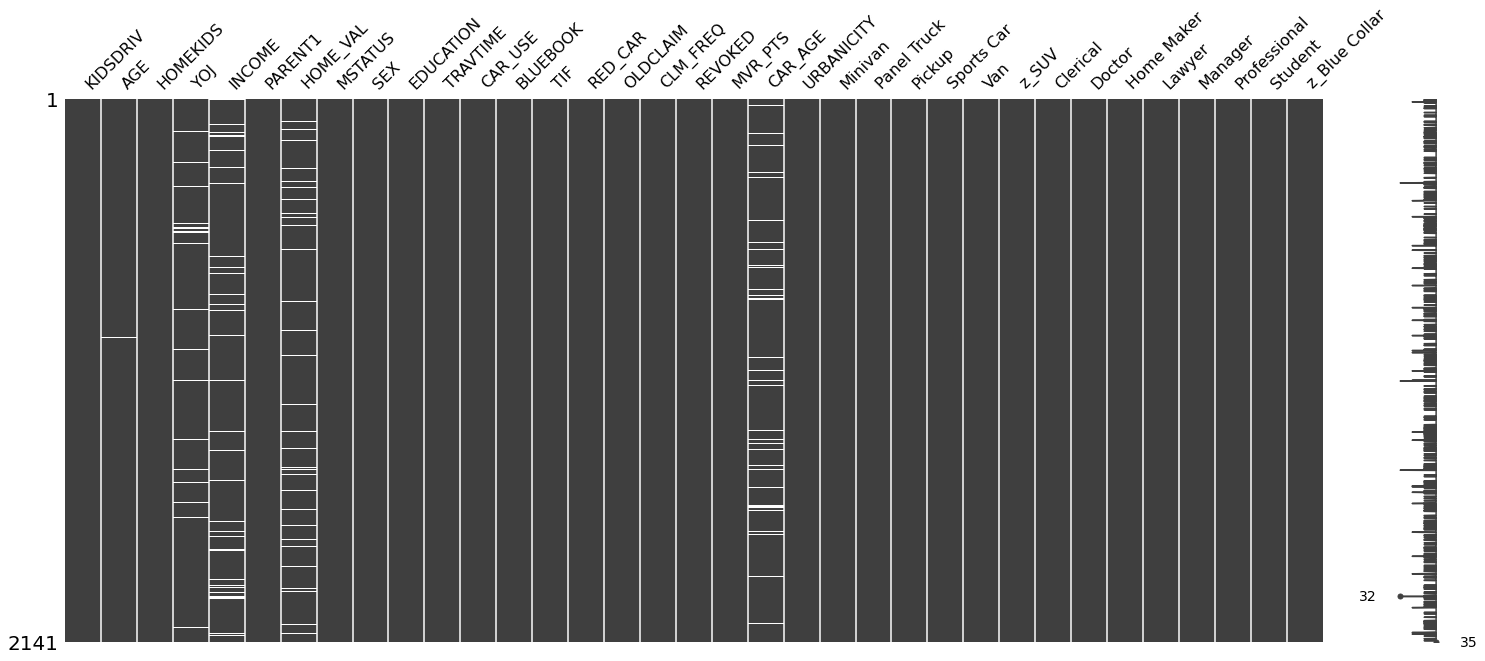


No duplicated entries found


In [42]:
# Load the test data
test_data = pd.read_csv('data/preprocessed_test.csv')
test_data.drop('TARGET_FLAG', axis = 1,inplace = True)

# Deal with the NaN's 
check_nan(test_data)
check_duplicate(test_data)
X_test = preprocessor.transform(test_data)

In [43]:
final_pred = lgb_classifier.predict(X_test)

In [44]:
final_sub = pd.DataFrame()
final_sub['TARGET_FLAG'] = final_pred
final_sub.to_csv('submission/final_submission.csv', index = False)